# Evaluate the seasonal climatology of winds for the Arctic
This notebook compares the seasonal climatology of wind stress across the Arctic using ECMWF's ERA5 and the following CM4 simulations:
1. CMIP6-CM4
2. Odiv-200
3. Odiv-209


In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
from glob import glob
import xarray as xr
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})
import numpy as np
import cmocean
import xesmf as xe

## Set parameters

## Set model paths

In [3]:
## CMIP6 CM4
# base
base = '/archive/oar.gfdl.cmip6/CM4/warsaw_201710_om4_v1.0.1/'
# specific pp directory
ppname = 'gfdl.ncrc4-intel16-prod-openmp/pp/atmos/av/'
# pi
cmip6_PI_dir = base + 'CM4_piControl_C/' + ppname + 'monthly_20yr/'
# CM4 historical
cmip6_HI_dir = base + 'CM4_historical/' + ppname + 'monthly_35yr/'

In [4]:
## High res experiments
# base
base = '/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210706/'
# specific pp directory
ppname = 'gfdl.ncrc4-intel18-prod-openmp/pp/atmos/av/'
## ODiv 209
# 1/8 degree MOM6 ocean with c192 atmosphere with remap scheme = P1M_H2 and MLE decay time at 20 days and 
# ice-albedo +1.0 tuning and land ice tuning F_iso = 0.8
odiv209_PI_dir = base + 'CM4_piControl_c192_OM4p125_v7/' + ppname + 'monthly_5yr/'
## ODiv 210
# 1/4 degree MOM6 ocean with c192 atmosphere with remap scheme = P1M_H2 and MLE decay time at 20 days and 
# ice-albedo +1.0 tuning and land ice tuning F_iso = 0.8
odiv210_PI_dir = base + 'CM4_piControl_c192_OM4p25_v7/' + ppname + 'monthly_5yr/'

## Get model file lists

In [5]:
## CMIP6 CM4
# pi
filelistCMIP6pi = glob(f'{cmip6_PI_dir}atmos.01*.nc')
# historical
filelistCMIP6hi = glob(f'{cmip6_HI_dir}*.nc')

In [6]:
## ODIV209 CM4
# pi
filelistODIV209 = glob(f'{odiv209_PI_dir}atmos.01*.nc')
# historical

In [7]:
## ODIV210 CM4
# pi
filelistODIV210 = glob(f'{odiv210_PI_dir}atmos.00*.nc')
# historical

## Read in model data
# SAVE THE LAND MASK AS WELL SO WE CAN IGNORE WINDS OVER LANDS WHEN TAKING AVERAGES OF MONTHLY BIASES

In [8]:
# List of atmos variables to keep
vlist = ['u_ref','v_ref'] # 10 m winds

In [9]:
# CMIP6 CM4 pi
DS_cmip6pi = xr.open_mfdataset(filelistCMIP6pi,engine='netcdf4')[vlist].chunk({'time':60})

In [10]:
# CMIP6 CM4 historical
DS_cmip6hi = xr.open_mfdataset(filelistCMIP6hi,engine='netcdf4')[vlist].chunk({'time':12})

In [11]:
# ODIV209 CM4
DS_o209 = xr.open_mfdataset(filelistODIV209,engine='netcdf4')[vlist].chunk({'time':120})

In [12]:
# ODIV210 CM4
DS_o210 = xr.open_mfdataset(filelistODIV210,engine='netcdf4')[vlist].chunk({'time':120})

## Set observational paths

In [13]:
era5_dir = '/work/Marion.Alberty/data/ERA5_pp/'

## Get file list

In [14]:
filelistERA5 = glob(f'{era5_dir}ERA5_climatology_*_10m_1979_2014.nc')

## Read in observational data

In [15]:
DS_era5 = xr.open_mfdataset(filelistERA5,engine='netcdf4').rename({"u10":"u_ref","v10":"v_ref","longitude":"lon","latitude":"lat"})

## Bin average into seasons and months

In [16]:
def M_and_S_average(DS):
    # get list of variables
    vlist = list(DS.keys())
    
    # Calculate means
    for vname in vlist:
        DS[vname + 'M'] = DS[vname].groupby('time.month').mean().chunk({'month':12})
        DS[vname + 'S'] = DS[vname].groupby('time.season').mean().chunk({'season':4})
    return DS

In [17]:
# CMIP6 CM4 pi
DS_cmip6pi = M_and_S_average(DS_cmip6pi)

In [18]:
# CMIP6 CM4 historical
DS_cmip6hi = M_and_S_average(DS_cmip6hi)

In [19]:
# ODIV209 CM4 pi
DS_o209 = M_and_S_average(DS_o209)

In [20]:
# ODIV210 CM4 pi
DS_o210 = M_and_S_average(DS_o210)

In [21]:
# ERA5
DS_era5 = M_and_S_average(DS_era5)

## Bin average era5 data to same grid as model output

In [22]:
def regrid(ds,ds_outgrid):
    # get out grid
    ds_grid = xr.Dataset(
        {
            "lat": (["lat"], ds_outgrid.lat.values),
            "lon": (["lon"], ds_outgrid.lon.values),
        }
    )
    # make regridder
    regridder = xe.Regridder(ds, ds_grid, "bilinear")
    # regrid input dataset
    ds_out = regridder(ds)
    return ds_out

In [23]:
# CMIP6 grid
DS_Ecmip6 = regrid(DS_era5,DS_cmip6hi)

using dimensions ('lat', 'lon') from data variable u_ref as the horizontal dimensions for this dataset.


In [24]:
# odiv-209 grid
DS_Eo209 = regrid(DS_era5,DS_o209)

using dimensions ('lat', 'lon') from data variable u_ref as the horizontal dimensions for this dataset.


In [25]:
# odiv-210 grid
DS_Eo210 = regrid(DS_era5,DS_o210)

using dimensions ('lat', 'lon') from data variable u_ref as the horizontal dimensions for this dataset.


## Calculate speeds

In [26]:
def speed(DS):
    # get u/v types
    vlist = list(set([a[1:] for a in list(DS.keys())]))
    
    for vname in vlist:
        DS['sp' + vname] = (DS['u' + vname]**2 + DS['v' + vname]**2)**(1/2)
    return DS

In [27]:
# CMIP6 CM4 pi
DS_cmip6pi = speed(DS_cmip6pi)

In [28]:
# CMIP6 CM4 historical
DS_cmip6hi = speed(DS_cmip6hi)

In [29]:
# ODIV209 pi
DS_o209 = speed(DS_o209)

In [30]:
# ODIV210 pi
DS_o210 = speed(DS_o210)

In [31]:
# ERA5 cmip6
DS_Ecmip6 = speed(DS_Ecmip6)

In [32]:
# ERA5 odiv209
DS_Eo209 = speed(DS_Eo209)

In [33]:
# ERA5 odiv210
DS_Eo210 = speed(DS_Eo210)

## Calculate biases

In [34]:
def biases(DS,OBS):
    # get list of variables
    vlist = [x for x in list(DS.keys()) if "S" in x or "M" in x]
    
    for vname in vlist:
        DS['bias_' + vname] = DS[vname] - OBS[vname]
    return DS

In [35]:
# CMIP6 CM4 pi
DS_cmip6pi = biases(DS_cmip6pi,DS_Ecmip6)

In [36]:
# CMIP6 CM4 historical
DS_cmip6hi = biases(DS_cmip6hi,DS_Ecmip6)

In [37]:
# ODIV209 pi
DS_o209 = biases(DS_o209,DS_Eo209)

In [38]:
# ODIV210 pi
DS_o210 = biases(DS_o210,DS_Eo210)

## Set up DASK cluster
In dask labextension, create a +NEW cluster. Click the < > widget, scale it to 16 workers and let's go!

## Plot biases

Make seasonal bias maps for above 60N showing:
1. the bias of the wind speed as a red-blue colormap
2. the modeled seasonal mean wind vector with black quivers
3. the bias wind vector with purple quivers

In [39]:
import cartopy.crs as ccrs
import copy
import matplotlib.cm as cm
import matplotlib.path as mpath
import cartopy.feature as cfeature

In [40]:
def windmaps(DS,sname):
    # make fig
    fig,ax = plt.subplots(figsize=(8,8),subplot_kw={'projection':ccrs.NorthPolarStereo(central_longitude=-100)})
    
    cmap = copy.copy(cm.RdBu_r)
    cmap.set_bad('darkgray')
    ax.set_extent([-180, 180, 55, 90], ccrs.PlateCarree())
    
    # Compute a circle in axes coordinates, which we can use as a boundary
    # for the map. We can pan/zoom as much as we like - the boundary will be
    # permanently circular.
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ax.set_boundary(circle, transform=ax.transAxes)

    im=ax.pcolormesh(DS["lon"],DS["lat"],DS.bias_sp_refS.sel(season=sname),cmap=cmap,
                     transform=ccrs.PlateCarree(),vmin=-5, vmax=5)

    # resample u and v for quiver
    resample = DS.sel(season=sname).isel(lon=slice(None, None, 7),lat=slice(None, None, 3))

    # q0=resample.plot.quiver(x='lon',y='lat',u='u_refS',v='v_refS',
    #                         transform=ccrs.PlateCarree(),color='black',scale=90,
    #                         scale_units='width')
    
    # q1=resample.plot.quiver(x='lon',y='lat',u='bias_u_refS',v='bias_v_refS',
    #                         transform=ccrs.PlateCarree(),color='purple',scale=100,
    #                         scale_units='width')

    plt.colorbar(im,ax=ax,
                 orientation='horizontal',
                 fraction=0.03,pad=0.01,
                 label='Wind Speed Bias [m/s]')

    ax.add_feature(cfeature.COASTLINE,zorder=10,color='gray')
    ax.gridlines()
    ax.set_title(DS.title + '\n' + sname)
    plt.show()
    
    # Save figure
    fig.savefig('../figures/ERA5/windspeed_' + DS.title + '_' + sname + '_bias_map.pdf')

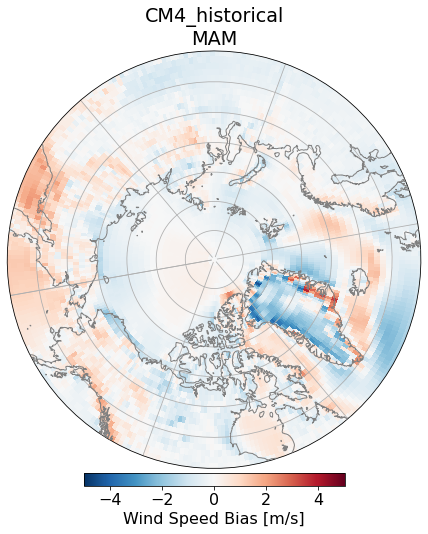

In [41]:
windmaps(DS_cmip6hi,'MAM')

Make plots of monthly rms errors in wind for all points north of 60N for:
1. wind speed
2. u component
3. v component

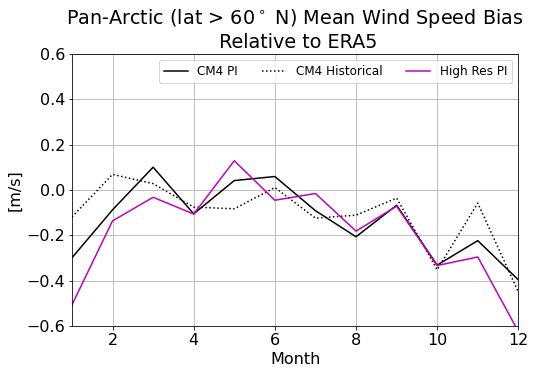

In [42]:
# Wind speed
fig = plt.figure(figsize=(8,5))
plt.plot(DS_cmip6pi.month,DS_cmip6pi.bias_sp_refM.sel(lat=slice(60,90)).mean(['lat','lon']),
         'k',label = 'CM4 PI')
plt.plot(DS_cmip6hi.month,DS_cmip6hi.bias_sp_refM.sel(lat=slice(60,90)).mean(['lat','lon']),
         'k:',label = 'CM4 Historical')
plt.plot(DS_o209.month,DS_o209.bias_sp_refM.sel(lat=slice(60,90)).mean(['lat','lon']),
         'm',label = 'High Res PI')
# Format
plt.title('Pan-Arctic (lat > 60$^\circ$ N) Mean Wind Speed Bias \n Relative to ERA5')
plt.ylabel('[m/s]')
plt.xlabel('Month')
plt.legend(ncol=3,prop={'size': 12})
plt.xlim(1,12)
plt.ylim(-0.6,0.6)
plt.grid()
plt.show()
# save fig
fig.savefig('../figures/ERA5/windspeed_monthly_bias_PanArctic.pdf')

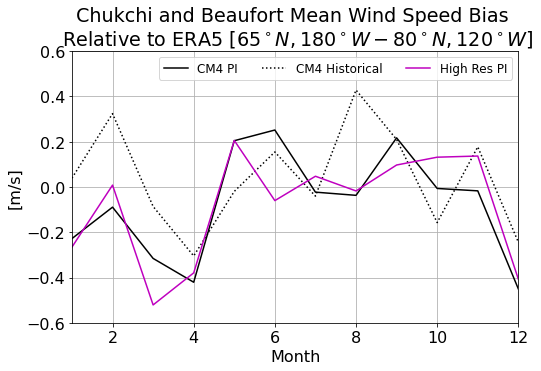

In [43]:
# Wind speed over western Arctic
fig = plt.figure(figsize=(8,5))
plt.plot(DS_cmip6pi.month,DS_cmip6pi.bias_sp_refM.sel(lat=slice(65,80),lon=slice(180,240)).mean(['lat','lon']),
         'k',label = 'CM4 PI')
plt.plot(DS_cmip6hi.month,DS_cmip6hi.bias_sp_refM.sel(lat=slice(65,80),lon=slice(180,240)).mean(['lat','lon']),
         'k:',label = 'CM4 Historical')
plt.plot(DS_o209.month,DS_o209.bias_sp_refM.sel(lat=slice(65,80),lon=slice(180,240)).mean(['lat','lon']),
         'm',label = 'High Res PI')
# Format
plt.title('Chukchi and Beaufort Mean Wind Speed Bias \n Relative to ERA5 [$65^\circ N, 180^\circ W - 80^\circ N, 120^\circ W$]')
plt.ylabel('[m/s]')
plt.xlabel('Month')
plt.legend(ncol=3,prop={'size': 12})
plt.xlim(1,12)
plt.ylim(-0.6,0.6)
plt.grid()
plt.show()
# save fig
fig.savefig('../figures/ERA5/windspeed_monthly_bias_CSBS.pdf')

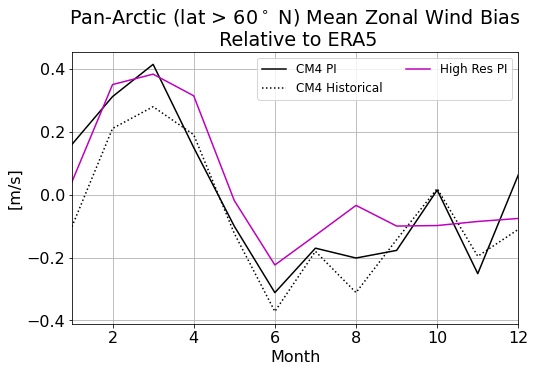

In [44]:
# u at 10m
fig = plt.figure(figsize=(8,5))
plt.plot(DS_cmip6pi.month,DS_cmip6pi.bias_u_refM.sel(lat=slice(60,90)).mean(['lat','lon']),
         'k',label = 'CM4 PI')
plt.plot(DS_cmip6hi.month,DS_cmip6hi.bias_u_refM.sel(lat=slice(60,90)).mean(['lat','lon']),
         'k:',label = 'CM4 Historical')
plt.plot(DS_o209.month,DS_o209.bias_u_refM.sel(lat=slice(60,90)).mean(['lat','lon']),
         'm',label = 'High Res PI')
# Format
plt.title('Pan-Arctic (lat > 60$^\circ$ N) Mean Zonal Wind Bias \n Relative to ERA5')
plt.ylabel('[m/s]')
plt.xlabel('Month')
plt.legend(ncol=2,prop={'size': 12})
plt.xlim(1,12)
plt.grid()
plt.show()
# save fig
fig.savefig('../figures/ERA5/u_ref_monthly_bias.pdf')

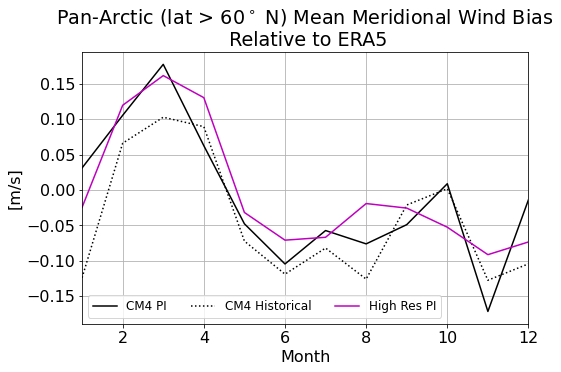

In [45]:
# v at 10m
fig = plt.figure(figsize=(8,5))
plt.plot(DS_cmip6pi.month,DS_cmip6pi.bias_v_refM.sel(lat=slice(60,90)).mean(['lat','lon']),
         'k',label = 'CM4 PI')
plt.plot(DS_cmip6hi.month,DS_cmip6hi.bias_v_refM.sel(lat=slice(60,90)).mean(['lat','lon']),
         'k:',label = 'CM4 Historical')
plt.plot(DS_o209.month,DS_o209.bias_v_refM.sel(lat=slice(60,90)).mean(['lat','lon']),
         'm',label = 'High Res PI')
# Format
plt.title('Pan-Arctic (lat > 60$^\circ$ N) Mean Meridional Wind Bias \n Relative to ERA5')
plt.ylabel('[m/s]')
plt.xlabel('Month')
plt.legend(ncol=3,prop={'size': 12})
plt.xlim(1,12)
plt.grid()
plt.show()
# save fig
fig.savefig('../figures/ERA5/v_ref_monthly_bias.pdf')